# PyTorch Custom Datasets

## 0. Importing PyTorch and setting device-agnostic code

In [1]:
import torch
from torch import nn

torch.__version__

'2.2.2+cu121'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

## 1. Get data

In [3]:
import requests
import zipfile
from pathlib import Path

data_path = Path( "data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
	print( f"{ image_path} directory already exists... skipping download")
else:
	print( f"{ image_path} does not exists, creating one...")
	image_path.mkdir( parents=True, exist_ok=True)

	zip_file_name = "pizza_steak_sushi.zip"

	# Download
	with open( data_path / zip_file_name, "wb") as f:
		print( "Downloading pizza, steak and sushi data...")
		request = requests.get( "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
		f.write( request.content)

	# Unzip
	with zipfile.ZipFile( data_path / zip_file_name, "r") as zip_ref:
		print( "Unzipping pizza, steak and sushi data...")
		zip_ref.extractall( image_path)

data\pizza_steak_sushi directory already exists... skipping download


## 2. Data prepration and data exploration

In [4]:
import os
def walk_through_dir( dir_path):
	"""Walks throght dir_path returning its contents"""

	for dirpath, dirnames, filenames in os.walk( dir_path):
		print( f"There are { len( dirnames)} directories and { len( filenames)} images in '{ dirpath}'.")

In [5]:
walk_through_dir( image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\test'.
There are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'.
There are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'.
There are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\train'.
There are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'.
There are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'.
There are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'.


### Setup train and testing paths

In [6]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

### Visualizing and image

Image path: data\pizza_steak_sushi\train\sushi\1070104.jpg
Image class: sushi
Image height: 384 | Image width: 512


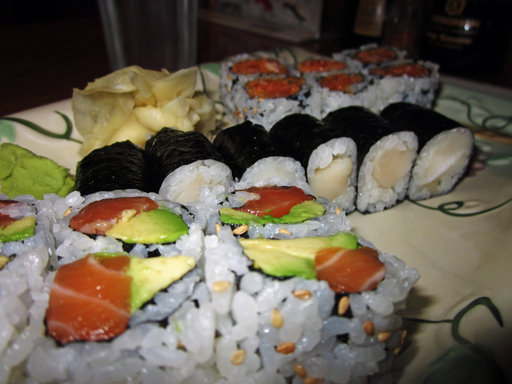

In [7]:
import random
from PIL import Image

# 1. Get all image paths
image_path_list = list( image_path.glob( "*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice( image_path_list)

print( f"Image path: { random_image_path}")

# 3. Get image class from path name
image_class = random_image_path.parent.stem

print( f"Image class: { image_class}")

# 4. Open image
img = Image.open( random_image_path)

# 5. Print metadata
print( f"Image height: { img.height} | Image width: { img.width}")

img

### Visualizing using `matplotlib`

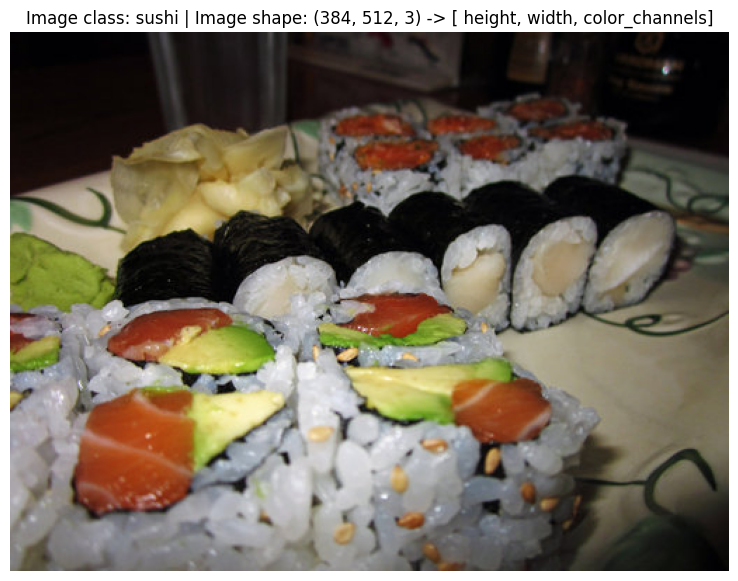

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray( img)

# Plot the image using matplot
plt.figure( figsize=( 10, 7))
plt.imshow( img_as_array)
plt.title( f"Image class: { image_class} | Image shape: { img_as_array.shape} -> [ height, width, color_channels]")
plt.axis( False)
plt.show()

## 3. Transforming data

In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

In [10]:
data_transform = transforms.Compose( [
	# Resize
	transforms.Resize( size=( 64, 64)),
	# Flip randomly
	transforms.RandomHorizontalFlip( p=0.5),
	# Turn image into torch tensor
	transforms.ToTensor()
])

In [11]:
data_transform( img).shape

torch.Size([3, 64, 64])

In [12]:
def plot_transformed_images( image_paths: list, transform, n=3, seed=None):
	"""
	Selects random images from a path of images and loads/transform 
	them then plots the original vs the transformed version
	"""

	if seed:
		random.seed( seed)

	random_image_paths = random.sample( image_paths, k=n)

	for image_path in random_image_paths:
		with Image.open( image_path) as f:
			fig, ax = plt.subplots( nrows=1, ncols=2)
			ax[ 0].imshow( f)
			ax[ 0].set_title( f"Original\nSize: { f.size}")
			ax[ 0].axis( False)

			# Transform and plot target image
			transformed_image = transform( f).permute( 1, 2, 0)
			ax[ 1].imshow( transformed_image)
			ax[ 1].set_title( f"Transformed\nSize: { transformed_image.shape}")
			ax[ 1].axis( "off")

			fig.suptitle( f"Class: { image_path.parent.stem}", fontsize=16)

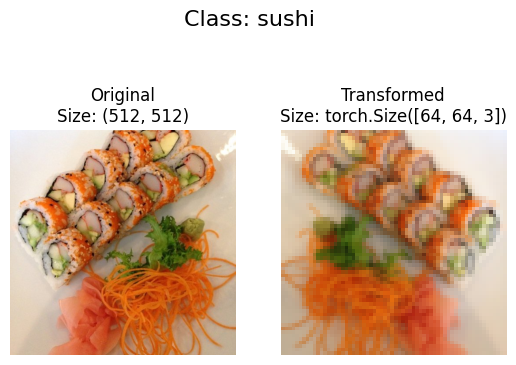

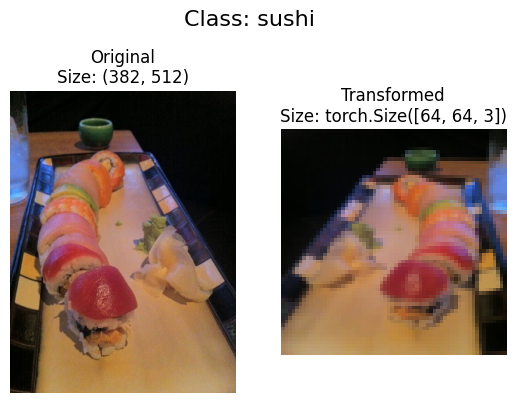

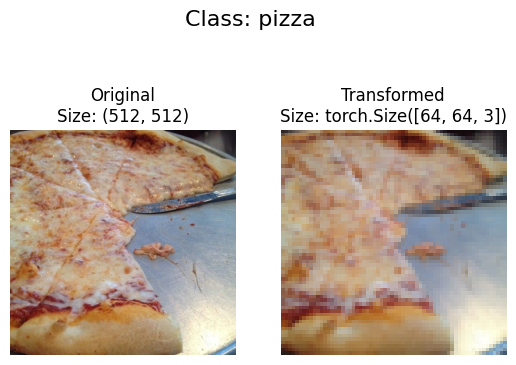

In [13]:
plot_transformed_images( image_paths=image_path_list,
						 transform=data_transform)

## 4. Option 1: Loading image data using `ImageFolder`

In [14]:
from torchvision import datasets

train_data = datasets.ImageFolder( root=train_dir,
								   transform=data_transform,
								   target_transform=None)

test_data = datasets.ImageFolder( root=test_dir,
								  transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [15]:
class_names = train_data.classes

class_names

['pizza', 'steak', 'sushi']

In [16]:
len( train_data), len( test_data)

(225, 75)

In [17]:
img, label = train_data[ 0]

print( f"Image tensor:\n { img}")
print( f"Image shape: { img.shape}")
print( f"Image datatype: { img.dtype}")
print( f"Image label: { label} | Image class name: { class_names[ label]}")
print( f"Label datatype: { type( label)}")

Image tensor:
 tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.0

Original shape: torch.Size([3, 64, 64]) -> [ C, H, W]
Image permute shape: torch.Size([64, 64, 3]) -> [ H, W, C]


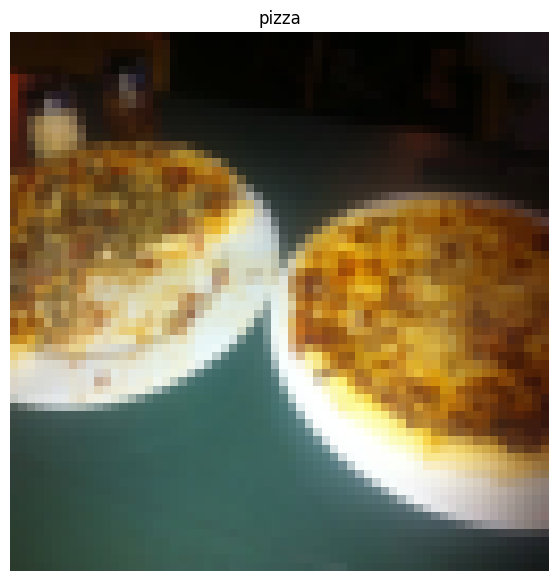

In [18]:
# rearrange the order of dimensions
img_permute = img.permute( 1, 2, 0)

print( f"Original shape: { img.shape} -> [ C, H, W]")
print( f"Image permute shape: { img_permute.shape} -> [ H, W, C]")

plt.figure( figsize=( 10, 7))
plt.imshow( img_permute)
plt.axis( False)
plt.title( class_names[ label])
plt.show()

### 4.1 Turn loaded images into `DataLoader`

In [19]:
import os
os.cpu_count()

12

In [20]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader( dataset=train_data,
							   batch_size=BATCH_SIZE,
							#    num_workers=os.cpu_count(),
							   shuffle=True)

test_dataloader = DataLoader( dataset=test_data,
							  batch_size=BATCH_SIZE,
							#   num_workers=os.cpu_count(),
							  shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x21553fad510>,
 <torch.utils.data.dataloader.DataLoader at 0x21554121a50>)

In [21]:
len( train_dataloader), len( test_dataloader)

(8, 3)

In [22]:
img, label = next( iter( train_dataloader))

print( f"Image shape: { img.shape} -> [ batch_size, color_channels, height, width]")
print( f"Label shape: { label.shape}")

Image shape: torch.Size([32, 3, 64, 64]) -> [ batch_size, color_channels, height, width]
Label shape: torch.Size([32])


## 5. Option 2: Loading Image Data with Custom `Dataset`

In [23]:
import os
import pathlib
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

### 5.1 Creating a helper function to get class names

In [24]:
# target_directory = train_dir

# print( f"Target dir: { target_directory}")

# class_names_found = sorted( [ entry.name for entry in list( os.scandir( target_directory))])

# print( f"Class Names: { class_names_found}")

def find_classes( directory: str) -> Tuple[ List[ str], Dict[ str, int]]:
	"""Finds the class folder names in a target directory"""

	# Get the class names by scanning the target directory
	classes = sorted( [ entry.name for entry in os.scandir( directory) if entry.is_dir()])

	if not classes:
		raise FileNotFoundError( f"Couldn't find any classes in { directory}... please check file structure.")

	# Create a dictionary of index labels
	class_to_idx = { class_name: i for i, class_name in enumerate( classes)}

	return classes, class_to_idx

In [25]:
find_classes( train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

In [26]:
class ImageFolderCustom( Dataset):
	def __init__( self, targ_dir: str, transform: None):
		self.paths = list( pathlib.Path( targ_dir).glob( "*/*.jpg"))
		self.transform = transform
		self.classes, self.class_to_idx = find_classes( targ_dir)

	def load_image( self, index: int) -> Image.Image:
		image_path = self.paths[ index]

		return Image.open( image_path)
	
	def __len__( self) -> int:
		return len( self.paths)
	
	def __getitem__( self, index) -> Tuple[ torch.Tensor, int]:
		img = self.load_image( index)
		class_name = self.paths[ index].parent.name
		class_idx = self.class_to_idx[ class_name]

		if self.transform:
			img = self.transform( img)
		
		return img, class_idx

In [27]:
train_transforms = transforms.Compose( [
	transforms.Resize( size=( 64, 64)),
	transforms.RandomHorizontalFlip( p=0.5),
	transforms.ToTensor()
])

test_transforms = transforms.Compose( [
	transforms.Resize( size=( 64, 64)),
	transforms.ToTensor()
])

In [28]:
train_data_custom = ImageFolderCustom( targ_dir=train_dir,
									   transform=train_transforms)

test_data_custom = ImageFolderCustom( targ_dir=test_dir,
									   transform=test_transforms)

train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x2155413dcd0>,
 <__main__.ImageFolderCustom at 0x21555467950>)

In [29]:
len( train_data), len( train_data_custom)

(225, 225)

In [30]:
len( test_data), len( test_data_custom)

(75, 75)

In [31]:
train_data_custom.classes, train_data_custom.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [32]:
print( train_data_custom.classes == train_data.classes)
print( test_data_custom.classes == test_data.classes)

True
True


### 5.3 Create a function to display random images

In [33]:
def display_random_images( dataset: torch.utils.data.Dataset,
						   classes: List[ str] = None,
						   n: int = 10,
						   display_shape: bool = True,
						   seed: int = None):
	if n > 10:
		n = 10
		print( f"For display purposes, n shouldn't be larger than 10, setting to 10")

	if seed:
		random.seed( seed)

	random_samples_idx = random.sample( range( len( dataset)), k=n)

	plt.figure( figsize=( 16, 8))

	for i, targ_sample in enumerate( random_samples_idx):
		targ_image, targ_label = dataset[ targ_sample]

		targ_image_adjust = targ_image.permute( 1, 2, 0)

		plt.subplot( 1, n, i + 1)
		plt.imshow( targ_image_adjust)
		plt.axis( False)

		if classes:
			title = f"Class: { classes[ targ_label]}"
			if display_shape:
				title = title + f"\nshape: { targ_image_adjust.shape}"

		plt.title( title)

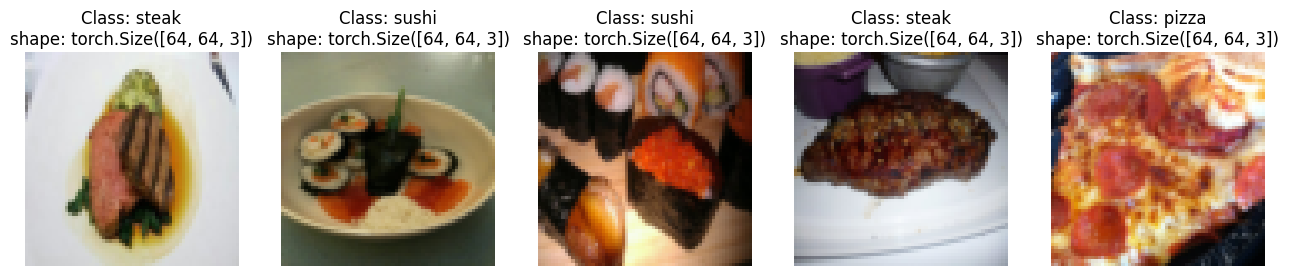

In [34]:
display_random_images( train_data_custom,
					   n=5,
					   classes=class_names)

### 5.4 Turn custom loaded images into `DataLoader`

In [35]:
BATCH_SIZE = 32

train_dataloader_custom = DataLoader( dataset=train_data_custom,
									  batch_size=BATCH_SIZE,
									  shuffle=True)

test_dataloader_custom = DataLoader( dataset=test_data_custom,
									batch_size=BATCH_SIZE,
									shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x215554739d0>,
 <torch.utils.data.dataloader.DataLoader at 0x2155413cfd0>)

In [36]:
img_custom, label_custom = next( iter( train_dataloader_custom))

img_custom.shape, label.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other forms of transforms (data augmentation)

In [37]:
from torchvision import transforms

train_transforms = transforms.Compose( [
	transforms.Resize( size=( 224, 224)),
	transforms.TrivialAugmentWide( num_magnitude_bins=31),
	transforms.ToTensor()
])


test_transforms = transforms.Compose( [
	transforms.Resize( size=( 224, 224)),
	transforms.ToTensor()
])

In [38]:
image_path_list = list( image_path.glob( "*/*/*.jpg"))

image_path_list[ :10]

[WindowsPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1687143.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/194643.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/195160.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2003290.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2019408.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2111981.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2124579.jpg')]

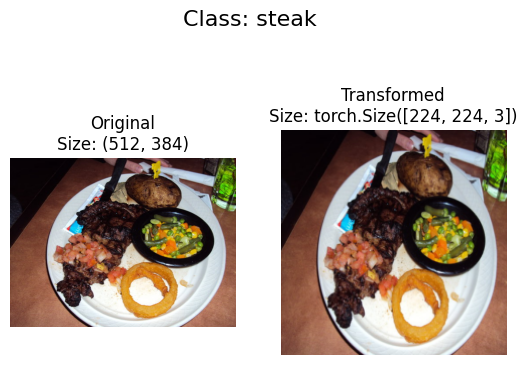

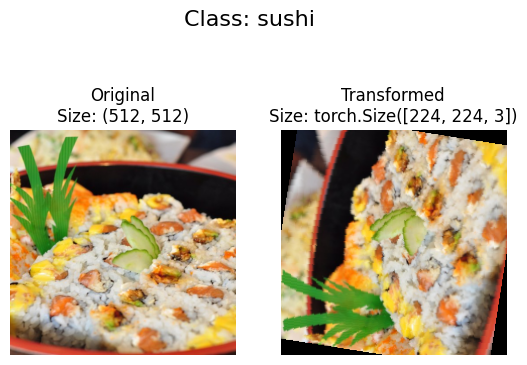

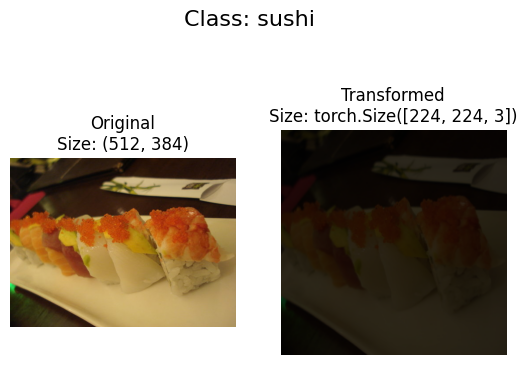

In [39]:
plot_transformed_images(
	image_path_list,
	train_transforms,
	n=3
)

## 7. Model 0: TinyVGG without data augmentation

### 7.1 Creating transforms and loading data for Model 0

In [40]:
simple_transform = transforms.Compose( [
	transforms.Resize( size=( 64, 64)),
	transforms.ToTensor()
])

In [41]:
train_data_simple = datasets.ImageFolder( root=train_dir,
										  transform=simple_transform)

test_data_simple = datasets.ImageFolder( root=test_dir,
										 transform=simple_transform)

BATCH_SIZE = 32

train_dataloader_simple = DataLoader( dataset=train_data_simple,
									  batch_size=BATCH_SIZE,
									  shuffle=True)

test_dataloader_simple = DataLoader( dataset=test_data_simple,
									batch_size=BATCH_SIZE,
									shuffle=False)

train_dataloader_simple, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x215557d3c90>,
 <torch.utils.data.dataloader.DataLoader at 0x215554df8d0>)

### 7.2 Create TinyVGG model class

In [42]:
class TinyVGG( nn.Module):
	def __init__( self, input_shape: int, 
			   	  hidden_unit: int,
				  output_shape: int) -> None:
		
		super().__init__()

		self.conv_block_1 = nn.Sequential(
			nn.Conv2d( in_channels=input_shape,
			 		   out_channels=hidden_unit,
					   kernel_size=3,
					   stride=1,
					   padding=0),
			nn.ReLU(),
			nn.Conv2d( in_channels=hidden_unit,
			 		   out_channels=hidden_unit,
					   kernel_size=3,
					   stride=1,
					   padding=0),
			nn.ReLU(),
			nn.MaxPool2d( kernel_size=2,
						  stride=2)
		)

		self.conv_block_2 = nn.Sequential(
			nn.Conv2d( in_channels=hidden_unit,
			 		   out_channels=hidden_unit,
					   kernel_size=3,
					   stride=1,
					   padding=0),
			nn.ReLU(),
			nn.Conv2d( in_channels=hidden_unit,
			 		   out_channels=hidden_unit,
					   kernel_size=3,
					   stride=1,
					   padding=0),
			nn.ReLU(),
			nn.MaxPool2d( kernel_size=2,
						  stride=2)
		)

		self.classifier = nn.Sequential(
			nn.Flatten(),
			nn.Linear( in_features=hidden_unit * 13 * 13,
			 		   out_features=output_shape)
		)

	def forward( self, x):
		# x = self.conv_block_1( x)
		# print( x.shape)
		# x = self.conv_block_2( x)
		# print( x.shape)
		# x = self.classifier( x)
		# print( x.shape)

		# return x
		
		return self.classifier( self.conv_block_2( self.conv_block_1( x)))

In [43]:
torch.manual_seed( 42)
model_0 = TinyVGG( input_shape=3,
				   hidden_unit=10,
				   output_shape=len( class_names)).to( device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image

In [44]:
image_batch, label_batch = next( iter( train_dataloader_simple))

image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [45]:
model_0( image_batch.to( device))

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4669e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9128e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6416e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0238e-02, -4.7978e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1817e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3994e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1470e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.1013e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

In [46]:
from torchinfo import summary
summary( model_0, input_size=[ 1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### 7.5 Create train and test loops functions

In [47]:
def train_step( model: torch.nn.Module,
			    dataloader: torch.utils.data.DataLoader,
				loss_fn: torch.nn.Module,
				optimizer: torch.optim.Optimizer,
				device=device):
	
	model.train()

	train_loss, train_acc = 0, 0
	
	for batch, ( X, y) in enumerate( dataloader):

		X, y = X.to( device), y.to( device)

		# 1. Forward pass
		y_pred = model( X)

		# 2. Calculate the loss
		loss = loss_fn( y_pred, y)

		train_loss += loss.item()

		# 3. Optimizer zero grad
		optimizer.zero_grad()

		# 4. Loss backward
		loss.backward()

		# 5. Optimizer step
		optimizer.step()

		y_pred_class = torch.argmax( torch.softmax( y_pred, dim=1), dim=1)

		train_acc += ( y_pred_class == y).sum().item() / len( y_pred)

	train_loss /= len( dataloader)
	train_acc /= len( dataloader)

	return train_loss, train_acc

In [48]:
def test_step( model: torch.nn.Module,
			   dataloader: torch.utils.data.DataLoader,
			   loss_fn: torch.nn.Module,
			   device=device):
	
	model.eval()

	test_loss, test_acc = 0, 0

	with torch.inference_mode():
		for batch, ( X, y) in enumerate( dataloader):

			X, y = X.to( device), y.to( device)

			# 1. Forward pass
			test_pred_logits = model( X)

			# 2. Calculate the loss
			loss = loss_fn( test_pred_logits, y)
			test_loss += loss.item()

			test_pred_labels = test_pred_logits.argmax( dim=1)
			test_acc += ( test_pred_labels == y).sum().item() / len( test_pred_labels)

		test_loss /= len( dataloader)
		test_acc /= len( dataloader)

		return test_loss, test_acc

### 7.6 Create a `fit()` function to combine `train_step()` and `test_step()`

In [49]:
from tqdm.auto import tqdm

def fit( model: torch.nn.Module,
		 train_dataloader: torch.utils.data.DataLoader,
		 test_dataloader: torch.utils.data.DataLoader,
		 optimizer: torch.optim.Optimizer,
		 loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
		 epochs: int = 5,
		 device=device):
	
	results = { "train_loss": [],
			    "train_acc": [],
				"test_loss": [],
				"test_acc": []}
	
	for epoch in tqdm( range( epochs)):
		train_loss, train_acc = train_step( model=model,
									 		dataloader=train_dataloader,
											loss_fn=loss_fn,
											optimizer=optimizer,
											device=device)
		
		test_loss, test_acc = test_step( model=model,
								  		 dataloader=test_dataloader,
										 loss_fn=loss_fn,
										 device=device)
		
		print( f"Epoch: { epoch + 1} | Train Loss: { train_loss:.4f} | Train Acc: { train_acc:.4f}% | Test Loss: { test_loss:.4f} | Test Acc: { test_acc:.4f}%")

		results[ "train_loss"].append( train_loss)
		results[ "train_acc"].append( train_acc)
		results[ "test_loss"].append( test_loss)
		results[ "test_acc"].append( test_acc)

	return results

### 7.7 Train and evaluate model 0

In [50]:
torch.manual_seed( 42)
torch.cuda.manual_seed( 42)

NUM_EPOCHS = 5

model_0 = TinyVGG( input_shape=3,
				   hidden_unit=10,
				   output_shape=len( train_data.classes)).to( device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam( params=model_0.parameters(), lr=0.001)

from timeit import default_timer as timer

start_timer = timer()

model_0_results = fit( model=model_0,
					   train_dataloader=train_dataloader_simple,
					   test_dataloader=test_dataloader_simple,
					   optimizer=optimizer,
					   loss_fn=loss_fn,
					   epochs=NUM_EPOCHS,
					   device=device)

end_time = timer()

print( f"Total training time: { end_time - start_timer:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Train Loss: 1.1063 | Train Acc: 0.3047% | Test Loss: 1.0983 | Test Acc: 0.3011%
Epoch: 2 | Train Loss: 1.0998 | Train Acc: 0.3281% | Test Loss: 1.0697 | Test Acc: 0.5417%
Epoch: 3 | Train Loss: 1.0869 | Train Acc: 0.4883% | Test Loss: 1.0808 | Test Acc: 0.4924%
Epoch: 4 | Train Loss: 1.0845 | Train Acc: 0.4023% | Test Loss: 1.0607 | Test Acc: 0.5833%
Epoch: 5 | Train Loss: 1.0663 | Train Acc: 0.4180% | Test Loss: 1.0658 | Test Acc: 0.5644%
Total training time: 8.128 seconds


### 7.8 Plot the loss curves of Model 0

In [51]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [52]:
def plot_loss_curves( results: Dict[ str, List[ float]]):
	loss = results[ "train_loss"]
	test_loss = results[ "test_loss"]

	accuracy = results[ "train_acc"]
	test_accuracy = results[ "test_acc"]
	
	epochs = range( len( results[ "train_loss"]))

	plt.figure( figsize=( 15, 7))

	plt.subplot( 1, 2, 1)
	plt.plot( epochs, loss, label="train loss")
	plt.plot( epochs, test_loss, label="test loss")
	plt.title( "Loss")
	plt.xlabel( "Epochs")
	plt.legend()

	plt.subplot( 1, 2, 2)
	plt.plot( epochs, accuracy, label="train accuracy")
	plt.plot( epochs, test_accuracy, label="test accuracy")
	plt.title( "Accuracy")
	plt.xlabel( "Epochs")
	plt.legend()

	plt.show()

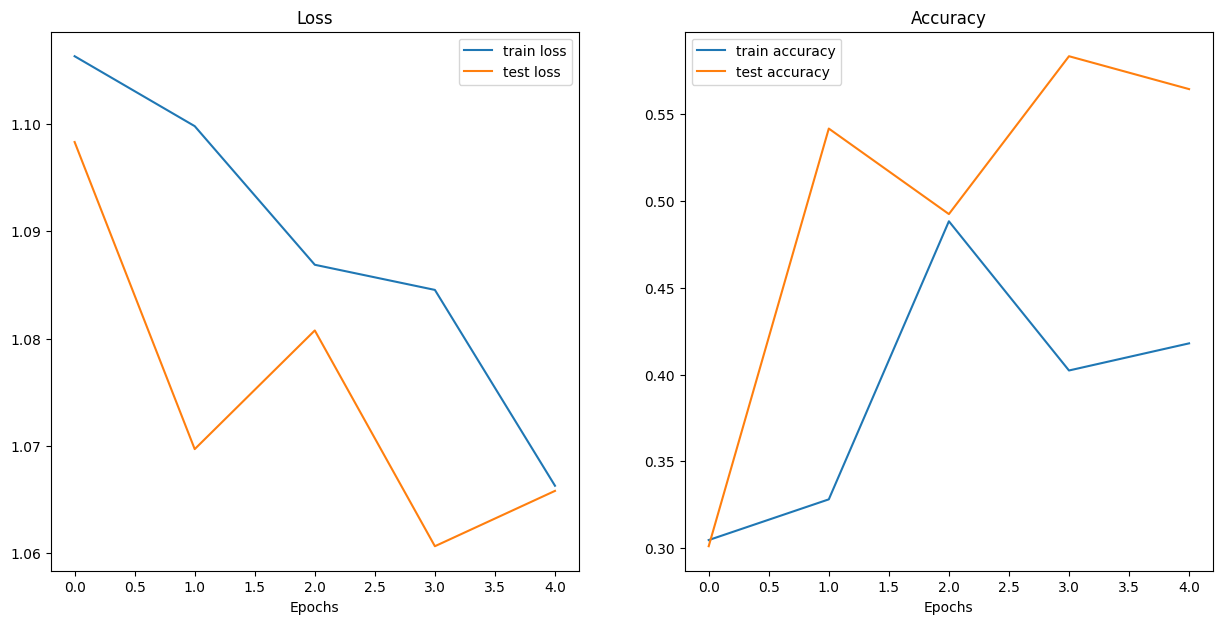

In [53]:
plot_loss_curves( results=model_0_results)

## 8. Model 1: TinyVGG with Data Augmentation

### 8.1 Create transform with data augmentation

In [54]:
train_transforms_trivial = transforms.Compose( [
	transforms.Resize( size=( 64, 64)),
	transforms.TrivialAugmentWide( num_magnitude_bins=31),
	transforms.ToTensor()
])

test_transform_simple = transforms.Compose( [
	transforms.Resize( size=( 64, 64)),
	transforms.ToTensor()
])

### 8.2 Create train and test `Dataset`s and `DataLoader`s with data augmentation

In [55]:
train_data_augmented = datasets.ImageFolder( root=train_dir,
											 transform=train_transforms_trivial)

test_data_simple = datasets.ImageFolder( root=test_dir,
										 transform=test_transform_simple)

In [56]:
torch.manual_seed( 42)

BATCH_SIZE = 32

train_dataloader_augmented = DataLoader( dataset=train_data_augmented,
										 batch_size=BATCH_SIZE,
										 shuffle=True)

test_dataloader_simple = DataLoader( dataset=test_data_simple,
									 batch_size=BATCH_SIZE,
									 shuffle=False)

### 8.3 Construct and train model 1

In [57]:
torch.manual_seed( 42)

model_1 = TinyVGG( input_shape=3,
				   hidden_unit=10,
				   output_shape=len( train_data_augmented.classes)).to( device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [58]:
torch.manual_seed( 42)
torch.cuda.manual_seed( 42)

NUM_EPOCHS = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam( params=model_1.parameters(), lr=0.001)

start_timer = timer()

model_1_results = fit( model=model_1,
					   train_dataloader=train_dataloader_augmented,
					   test_dataloader=test_dataloader_simple,
					   optimizer=optimizer,
					   loss_fn=loss_fn,
					   epochs=NUM_EPOCHS,
					   device=device)

end_time = timer()

print( f"Total training time for model_1: { end_time - start_timer} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Train Loss: 1.1036 | Train Acc: 0.2500% | Test Loss: 1.1010 | Test Acc: 0.2604%
Epoch: 2 | Train Loss: 1.0721 | Train Acc: 0.4258% | Test Loss: 1.1420 | Test Acc: 0.2604%
Epoch: 3 | Train Loss: 1.1431 | Train Acc: 0.3047% | Test Loss: 1.1623 | Test Acc: 0.2604%
Epoch: 4 | Train Loss: 1.0853 | Train Acc: 0.4258% | Test Loss: 1.1024 | Test Acc: 0.2604%
Epoch: 5 | Train Loss: 1.0973 | Train Acc: 0.3047% | Test Loss: 1.0879 | Test Acc: 0.2604%
Total training time for model_1: 9.875887400005013 seconds


### 8.4 Plot the loss curves of model 1

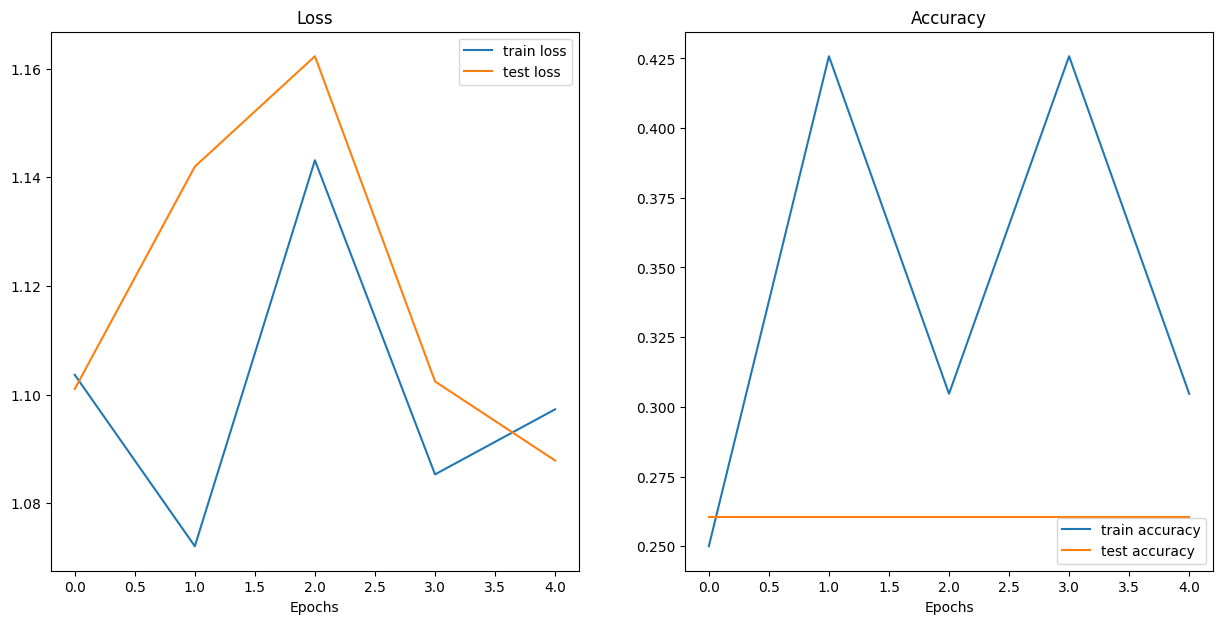

In [59]:
plot_loss_curves( model_1_results)

## 9. Compare model results

In [60]:
import pandas as pd

model_0_df = pd.DataFrame( model_0_results)
model_1_df = pd.DataFrame( model_1_results)

model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.106321,0.304688,1.098326,0.301136
1,1.099804,0.328125,1.069704,0.541667
2,1.086885,0.488281,1.080763,0.492424
3,1.084541,0.402344,1.060654,0.583333
4,1.066290,0.417969,1.065811,0.564394


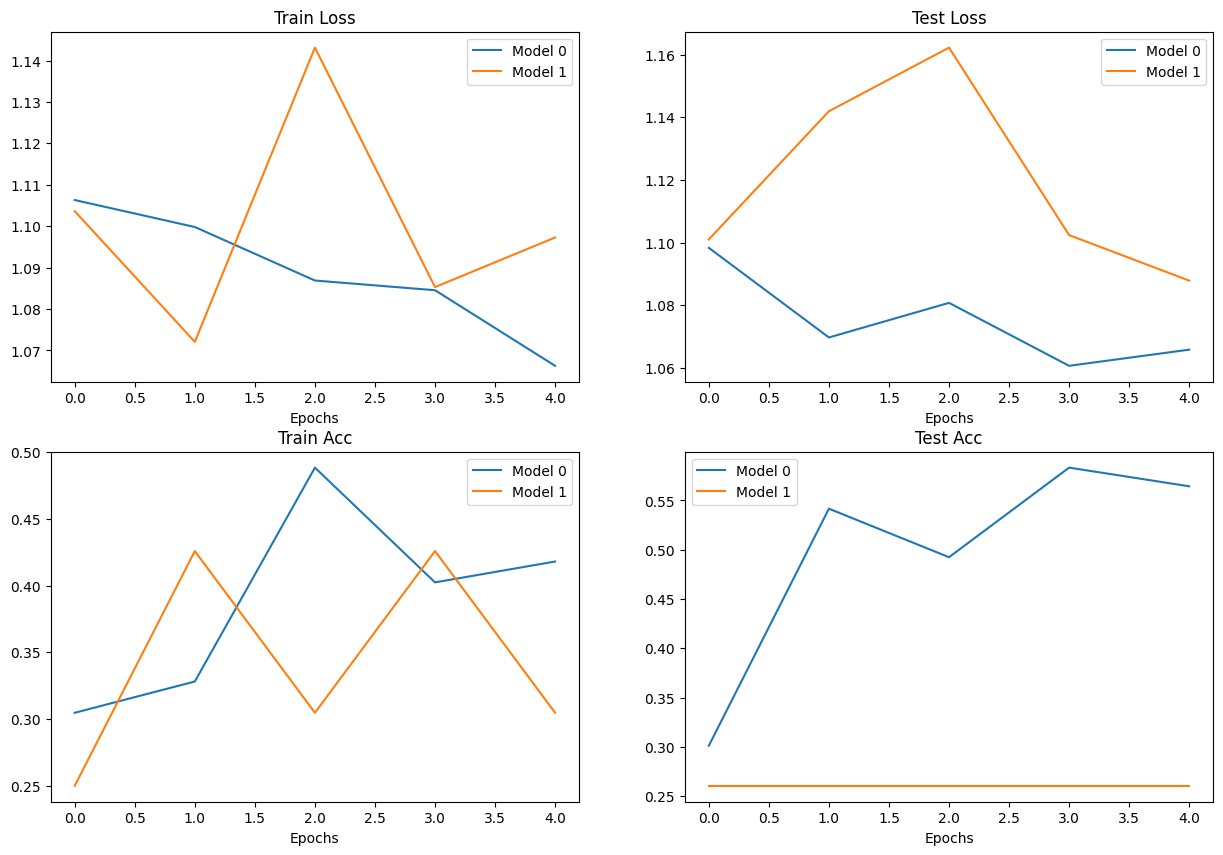

In [61]:
plt.figure( figsize=( 15, 10))

epochs = range( len( model_0_df))

plt.subplot( 2, 2, 1)
plt.plot( epochs, model_0_df[ "train_loss"], label="Model 0")
plt.plot( epochs, model_1_df[ "train_loss"], label="Model 1")
plt.title( "Train Loss")
plt.xlabel( "Epochs")
plt.legend()

plt.subplot( 2, 2, 2)
plt.plot( epochs, model_0_df[ "test_loss"], label="Model 0")
plt.plot( epochs, model_1_df[ "test_loss"], label="Model 1")
plt.title( "Test Loss")
plt.xlabel( "Epochs")
plt.legend()

plt.subplot( 2, 2, 3)
plt.plot( epochs, model_0_df[ "train_acc"], label="Model 0")
plt.plot( epochs, model_1_df[ "train_acc"], label="Model 1")
plt.title( "Train Acc")
plt.xlabel( "Epochs")
plt.legend()

plt.subplot( 2, 2, 4)
plt.plot( epochs, model_0_df[ "test_acc"], label="Model 0")
plt.plot( epochs, model_1_df[ "test_acc"], label="Model 1")
plt.title( "Test Acc")
plt.xlabel( "Epochs")
plt.legend()

plt.show()